In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from mcc import Contract, ResolvableContract, EuropeanOption, Zero, One, Give, Scale, And, Or, Until, KonstFloat, FX, GeometricBrownianMotion, Model

In [2]:
@dataclass
class FxCall(ResolvableContract):
    maturity: np.datetime64
    notional: float
    strike: float
    base_currency: str
    counter_currency: str
    
    def resolve(self) -> Contract:
        fw = And(Scale(KonstFloat(self.strike), One(self.counter_currency)), Give(One(self.base_currency)))
        opt = EuropeanOption(self.maturity, fw)
        return Scale(KonstFloat(self.notional), opt.resolve())

In [3]:
maturity = np.datetime64("2021-06-01")
notional = 10000000
strike = 1.10
base_currency = "EUR"
counter_currency = "USD"

In [4]:
fxcall = FxCall(maturity, notional, strike, base_currency, counter_currency)
fxcall.resolve()

Scale(observable=KonstFloat(constant=10000000), contract=When(observable=At(date=numpy.datetime64('2021-06-01')), contract=Or(contract1=And(contract1=Scale(observable=KonstFloat(constant=1.1), contract=One(currency='USD')), contract2=Give(contract=One(currency='EUR'))), contract2=Zero())))

In [5]:
spot = 1.15
volatility = 0.2
dategrid = np.array([
    np.datetime64("2021-01-01"),
    np.datetime64("2021-02-01"),
    np.datetime64("2021-03-01"),
    np.datetime64("2021-04-01"),
    np.datetime64("2021-05-01"),
    np.datetime64("2021-06-01")])
timegrid = np.linspace(0, 5 / 12, 6)

(100, 6)

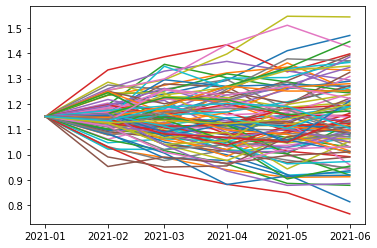

In [6]:
n = 100
rnd = np.random.RandomState(123)
gbm = GeometricBrownianMotion(mu=0, sigma=volatility)
x = spot * gbm.simulate(timegrid, n, rnd)
plt.plot(dategrid, x.T)
x.shape

In [7]:
model = Model(dategrid, {("EUR", "USD"): x}, {}, np.ones(x.shape), "EUR")

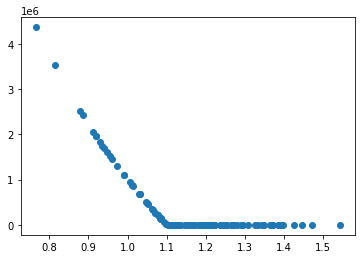

In [8]:
indexedcf = fxcall.generate_cashflows(model.eval_date_index, model)
cf_eur = model.in_numeraire_currency(indexedcf).apply_index()
netcf_eur = cf_eur.cashflows["value"].sum(axis=1)
plt.scatter(x[:,-1], netcf_eur);